# CSC345/M45 Big Data and Machine LearningCoursework: Object Recognition
## Ethan Young - 954408
**Self-Task: Comparing 3 model architectures on a subset of CIFAR-10 image dataset** 

## Imports

First we must import the packages that we will be using in this Coursework. We will use numpy, matplotlib, sci-kit Image and tensorflow.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature
import tensorflow as tf
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

## Load Data

Load in the data from numpy files, and transpose the 2 image datasets to reshuffle the dimensions so that the number of samples is the first dimension (not the last).  
**NOTE: Best to reload this cell before selecting a Method**

In [15]:
train_image = np.load('trnImage.npy')
train_image = np.transpose(train_image, [3, 0, 1, 2])
train_label = np.load('trnLabel.npy')
test_image = np.load('tstImage.npy')
test_image = np.transpose(test_image, [3, 0, 1, 2])
test_label = np.load('tstLabel.npy')

## Extract Hog Features
**NOTE: Run This before Running Method 1 SVM (only used for method 1)**  
Creates the 2 matrices of Shape S x F where S is the number of samples and F is the number of features from the hog() function. for the train and test image sets. The shape is printed.

In [23]:
train_hog = []
test_hog = []
for i in range(train_image.shape[0]):
    image = train_image[i, :, :, :]
    hog_feature = skimage.feature.hog(image, pixels_per_cell=[2,2], cells_per_block=[3,3], visualize=False)
    train_hog.append(hog_feature)
for i in range(test_image.shape[0]):
    image = train_image[i, :, :, :]
    hog_feature = skimage.feature.hog(image, pixels_per_cell=[2,2], cells_per_block=[3,3], visualize=False)
    test_hog.append(hog_feature)
train_hog = np.array(train_hog)
test_hog = np.array(test_hog)
print(train_hog.shape)
print(test_hog.shape)

(10000, 15876)
(1000, 15876)


## Method 1 - Support Vector Machine (SVM) using HOG Features
**NOTE: something is going wrong to output a precision mean model score so low which will be explained more in the paper, however not sure, after some research might be due to harsh score metric, and I should be using predict() instead possibly. Slight confusion with this one, massive time-sink so moved onto other methods instead.**


In [28]:
train_label = train_label.ravel()
test_label = test_label.ravel()

support_Vector = LinearSVC(max_iter=1000000)
support_Vector.fit(train_hog, train_label)
print()
print("Precision mean of model Score:")
print(support_Vector.score(test_hog, test_label))


Precision mean of model Score:
0.093


## Method 2 - Neural Network (NN)
Reshuffles the data for unbiased training, reshapes the data matrix to shape S x F instead of a 4 dimensional matrix. Normalises the data (Data is already normalised but I do it anyway for good practice). A sequential NN with 2 hidden layers of n = 6000 are created with ReLU activation (6000 is arbitrary but about 2/3 of the number of samples in the training set, and between the number of samples and output nodes) SGD optimizer is chosen as the network is quite shallow, only played around with Adam as well, but that performs better on a deeper network. loss and accuracy metrics used for when we plot the model accuracy and loss curves. Chosen 20 epochs (Same with CNN) for comparison sake with CNN and computation time.

Epoch 1/20
250/250 [==============================] - 20s 79ms/step - loss: 1.8730 - sparse_categorical_accuracy: 0.3288 - val_loss: 1.7068 - val_sparse_categorical_accuracy: 0.3920
Epoch 2/20
250/250 [==============================] - 23s 90ms/step - loss: 1.5073 - sparse_categorical_accuracy: 0.4830 - val_loss: 1.6470 - val_sparse_categorical_accuracy: 0.4055
Epoch 3/20
250/250 [==============================] - 22s 86ms/step - loss: 1.2834 - sparse_categorical_accuracy: 0.5645 - val_loss: 1.5833 - val_sparse_categorical_accuracy: 0.4315
Epoch 4/20
250/250 [==============================] - 22s 87ms/step - loss: 1.0747 - sparse_categorical_accuracy: 0.6405 - val_loss: 1.5813 - val_sparse_categorical_accuracy: 0.4680
Epoch 5/20
250/250 [==============================] - 22s 88ms/step - loss: 0.8849 - sparse_categorical_accuracy: 0.7228 - val_loss: 1.6643 - val_sparse_categorical_accuracy: 0.4380
Epoch 6/20
250/250 [==============================] - 22s 87ms/step - loss: 0.6997 - spars

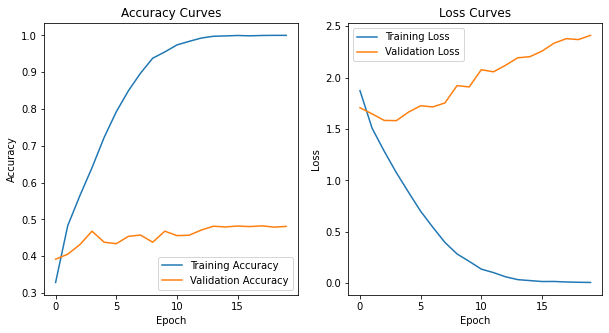

In [16]:
indices = np.arange(train_image.shape[0])
np.random.shuffle(indices)
train_image = train_image[indices, :, :, :]
train_label = train_label[indices, :]

train_image = train_image.reshape(10000, 3072)
test_image = test_image.reshape(1000, 3072)

normaliser = StandardScaler()
train_image = normaliser.fit_transform(train_image)
test_image = normaliser.transform(test_image)

model = tf.keras.Sequential(layers=[
    tf.keras.layers.Dense(3000, activation=tf.nn.relu),
    tf.keras.layers.Dense(2000, activation=tf.nn.relu),
    tf.keras.layers.Dense(1000, activation=tf.nn.relu),
    tf.keras.layers.Dense(500, activation=tf.nn.relu),
    tf.keras.layers.Dense(len(np.unique(train_label)), activation=tf.nn.softmax)])

model.compile(optimizer=tf.keras.optimizers.SGD(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=tf.keras.metrics.SparseCategoricalAccuracy(),)

history = model.fit(train_image, train_label, epochs=20, validation_split=0.2, verbose=1)
model.summary()

results = model.evaluate(test_image, test_label)
print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()

## Method 3 - Convolutional Neural Network (CNN)
Reshuffles the data for unbiased training, data is already in the correct shape as CNN's accept the 4d matrix for image processing due to the filters going through the image and colour channels. Created 3 convolutional layers with 3 pooling layers in between. The convultional layers are of increasing number of filters (powers of 2, 32-64-128) as the deeper we go through the network, the more complex the patterns become. The pooling layers act as another way of down sampling our feature map (reducing the number of pixels or values). The multi-dimensional network is then flattened before being passed into the last dense layer for output classification. Here I use Adam optimizer as it performs better on a deeper network than say SGD. Same loss and accuracy metrics as NN for plotting. 

Epoch 1/20
250/250 [==============================] - 11s 43ms/step - loss: 1.8608 - sparse_categorical_accuracy: 0.3192 - val_loss: 1.5451 - val_sparse_categorical_accuracy: 0.4360
Epoch 2/20
250/250 [==============================] - 13s 50ms/step - loss: 1.4805 - sparse_categorical_accuracy: 0.4610 - val_loss: 1.3735 - val_sparse_categorical_accuracy: 0.5005
Epoch 3/20
250/250 [==============================] - 13s 50ms/step - loss: 1.2936 - sparse_categorical_accuracy: 0.5395 - val_loss: 1.3529 - val_sparse_categorical_accuracy: 0.5145
Epoch 4/20
250/250 [==============================] - 12s 50ms/step - loss: 1.1634 - sparse_categorical_accuracy: 0.5878 - val_loss: 1.2282 - val_sparse_categorical_accuracy: 0.5665
Epoch 5/20
250/250 [==============================] - 12s 50ms/step - loss: 1.0258 - sparse_categorical_accuracy: 0.6401 - val_loss: 1.1520 - val_sparse_categorical_accuracy: 0.5865
Epoch 6/20
250/250 [==============================] - 13s 52ms/step - loss: 0.9103 - spars

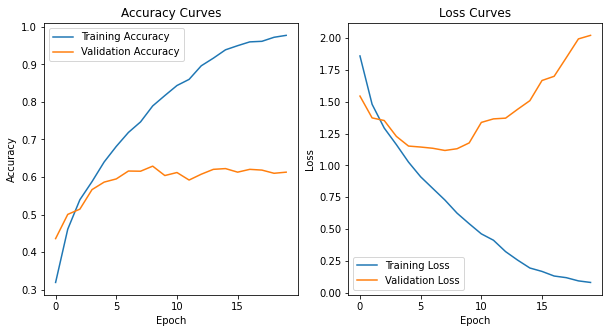

In [81]:
indices = np.arange(train_image.shape[0])
np.random.shuffle(indices)
train_image = train_image[indices, :, :, :]
train_label = train_label[indices, :]

model = tf.keras.Sequential(layers=[
    tf.keras.layers.Conv2D(32, 3, input_shape=train_image.shape[1:], activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(64, 3, input_shape=train_image.shape[1:], activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Conv2D(128, 3, input_shape=train_image.shape[1:], activation=tf.nn.relu, padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(len(np.unique(train_label)), activation=tf.nn.softmax)])

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              metrics=tf.keras.metrics.SparseCategoricalAccuracy(),)

history = model.fit(train_image, train_label, epochs=20, validation_split=0.2, verbose=1)
model.summary()

results = model.evaluate(test_image, test_label)
print(f'Test set loss: {results[0]:0.2f}, test set accuracy: {results[1]*100:0.2f}%')

plt.figure(figsize=[10,5])
plt.subplot(121)
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy',
           'Validation Accuracy'])
plt.title('Accuracy Curves')

plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss',
           'Validation Loss'])
plt.title('Loss Curves')
plt.show()